In [7]:
from google.colab import files
uploaded = files.upload()

Saving edgelist24.csv to edgelist24.csv


In [3]:
# In Google Colab, this cell installs graph-tools
!echo "deb http://downloads.skewed.de/apt/bionic bionic universe" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool

Executing: /tmp/apt-key-gpghome.s8taKLlEty/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 http://downloads.skewed.de/apt/bionic bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machin

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import seaborn as sns
import matplotlib.pyplot as plt 
from graph_tool.all import *

In [8]:
# Read files
df = pd.read_csv('edgelist24.csv')
df.head()


,source,target,weight
0,GERARDidi,jlmelenchon,235
1,GERARDidi,mlp_officiel,233
2,GERARDidi,larem_an,216
3,GERARDidi,eelv,215
4,GERARDidi,laurentwauquiez,209


In [ ]:
# Nodes
users = list(set(df.source).union(df.target.values))

# Create graph
g = Graph()
g.add_vertex(len(users))

# Add nodes id
v_id = g.new_vp("string", vals = users)
g.vp['v_id'] = v_id 

# Dictionary to map nodes to graph-tool vertices
vmap = {}
for i, v in enumerate(g.vertices()):
    vmap[users[i]] = v

In [7]:
print(v_id.get_2d_array([0]))

[['hayastaann' 'bonnafu' 'iflorennes92' ... 'Bond007_7' 'elisabeth_jutel'
  'ganser59']]


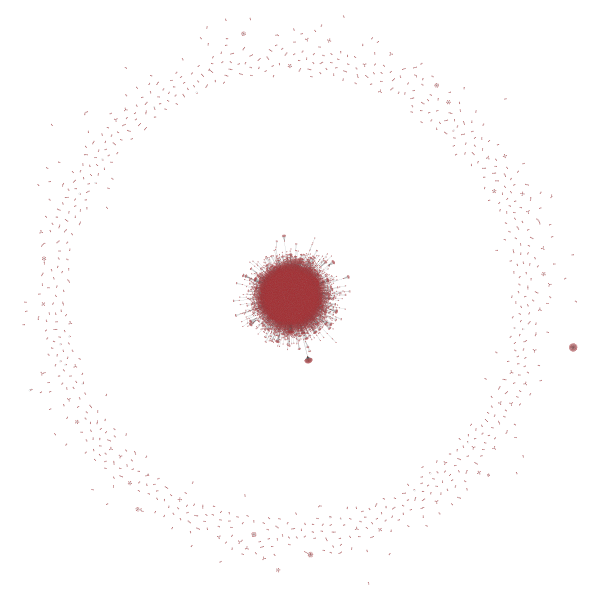

In [8]:
# Edge attributes
e_weight = g.new_ep("double")    

# Add edges
for r in range(len(df)):
    try:
        e = g.add_edge(vmap[df.source.iloc[r]],vmap[df.target.iloc[r]])
        e_weight[e] = df.weight.iloc[r]   
    except:
        pass   

g.ep['e_weight'] = e_weight
tpos = graph_draw(g);
v_pos = g.new_vp("vector<double>",vals = tpos)  
g.vp['v_pos'] = v_pos

In [9]:
print("Number of nodes: ", g.num_vertices())
print("Number of edges: ", g.num_edges())
print(g.list_properties())

Number of nodes:  31812
Number of edges:  93148
v_id           (vertex)  (type: string)
v_pos          (vertex)  (type: vector<double>)
e_weight       (edge)    (type: double)
None


In [ ]:
# Consider the largest connected component
#c = label_largest_component(g, directed=False)
#u = GraphView(g, vfilt=c)
u = extract_largest_component(g,directed=False, prune=True) # this is necessary for plotting H-SBM, when having only GraphView estimations are possible but not plots. 

In [ ]:
# Plot the network
graph_draw(u, pos = u.vp.v_pos);

### Strength and Betweenness

In [ ]:
# In-strenght
s_in = u.degree_property_map("in", u.ep.e_weight)
# Out-strength
s_out = u.degree_property_map("out", u.ep.e_weight)

In [ ]:
# Betweenness Centrality
vb, eb = betweenness(u, weight = u.ep.e_weight,  norm = False)

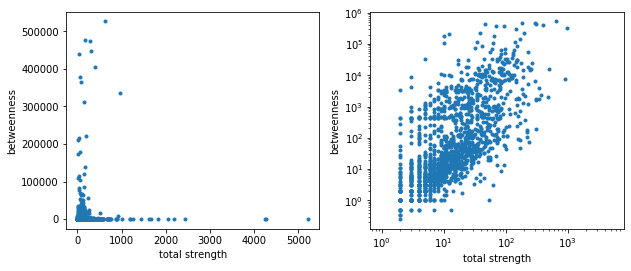

In [ ]:
total_strength = s_in.fa + s_out.fa
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].plot(total_strength,vb.fa, '.')
ax[0].set_xlabel('total strength')
ax[0].set_ylabel('betweenness')

ax[1].plot(total_strength,vb.fa, '.')
plt.xscale('log')
plt.yscale('log')
ax[1].set_xlabel('total strength')
ax[1].set_ylabel('betweenness');

The plot on the left suggests an **inverse** relation between strength and betweeness (although not linear), i.e., those accounts that are more connected are not those which are more relevant to allow information flow,and viceversa. Note that in logarithmic scale, those outliers from strength dissappear. Now, it seems there is a **positive** linear relationship between such centralities! In order to be important in terms of information flow, you need to be somehow connected. Among the highly connected people are mass media and politicians, which either receive or send tweets, but not both!


In [ ]:
from scipy.stats import pearsonr, kendalltau

print("In linear scale:")
print("Pearson's Correlation Coefficient: ",pearsonr(vb.fa,total_strength)[0],", pvalue = ", pearsonr(vb.fa,total_strength)[1])
print("Kendall's Tau: ", kendalltau(vb.fa,total_strength)[0], ", pvalue = ", kendalltau(vb.fa,total_strength)[1])

print("In logarithmic scale:")
print("Pearson's Correlation Coefficient: ",pearsonr(np.log(vb.fa[vb.fa>0]),np.log(total_strength[vb.fa>0]))[0],", pvalue = ", pearsonr(np.log(vb.fa[vb.fa>0]),np.log(total_strength[vb.fa>0]))[1])
print("Kendall's Tau: ", kendalltau(np.log(vb.fa[vb.fa>0]),np.log(total_strength[vb.fa>0]))[0], ", pvalue = ", kendalltau(np.log(vb.fa[vb.fa>0]),np.log(total_strength[vb.fa>0]))[1])

In linear scale:
Pearson's Correlation Coefficient:  0.09713907408317221 , pvalue =  6.38492450158172e-64
Kendall's Tau:  0.2507229985503627 , pvalue =  0.0
In logarithmic scale:
Pearson's Correlation Coefficient:  0.7261125024436246 , pvalue =  1.2746621149184018e-260
Kendall's Tau:  0.5867973512322237 , pvalue =  1.188572849451383e-256


### Clustering

In [ ]:
print("Average clustering coefficient:") 
print("Undirected unweighted network: ", np.round(np.mean(local_clustering(u).fa),3))
print("Undirected weighted network: ", np.round(np.mean(local_clustering(u,weight=u.ep.e_weight).fa),3))
print("Directed unweighted network: ", np.round(np.mean(local_clustering(u,undirected=False).fa),3))
print("Directed weighted network: ", np.round(np.mean(local_clustering(u,weight=u.ep.e_weight,undirected=False).fa),3))

Average clustering coefficient:
Undirected unweighted network:  0.021
Undirected weighted network:  0.052
Directed unweighted network:  0.003
Directed weighted network:  0.011


### Correlations

In [ ]:
# Assortativity
print(np.round(assortativity(u, "in", eweight=u.ep.e_weight),5),
np.round(assortativity(u, "out", eweight=u.ep.e_weight),5),
np.round(assortativity(u, "total", eweight=u.ep.e_weight),5))

[0.00142 0.0007 ] [0.00137 0.00057] [-0.0022   0.00066]


In [ ]:
# Scalar Assortativity
print(np.round(scalar_assortativity(u, "in", eweight=u.ep.e_weight),5),
np.round(scalar_assortativity(u, "out", eweight=u.ep.e_weight),5),
np.round(scalar_assortativity(u, "total", eweight=u.ep.e_weight),5))

[0.00414 0.00858] [0.03585 0.00665] [-0.05165  0.01703]


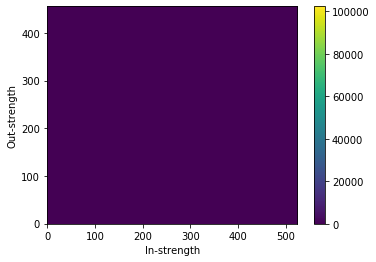

In [ ]:
# Correlation histogram
h = corr_hist(u, "in", "out", weight=u.ep.e_weight)
plt.clf()
plt.xlabel("In-strength")
plt.ylabel("Out-strength")
plt.imshow(h[0].T, interpolation="nearest", origin="lower")
plt.colorbar();

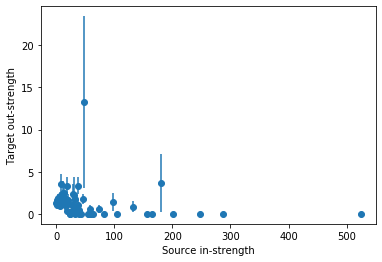

In [ ]:
# Average neighbor-neighbor correlation
h = avg_neighbor_corr(u, "in", "out",weight=u.ep.e_weight)
plt.clf()
plt.xlabel("Source in-strength")
plt.ylabel("Target out-strength")
plt.errorbar(h[2][:-1], h[0], yerr=h[1], fmt="o");

### Edge reciprocity

In [ ]:
edge_reciprocity(u)

0.001835260900255199

## Community Detection (using SBM)

In [ ]:
# Unweighted network
# The number of groups is not set a priori
state = minimize_blockmodel_dl(u)
print(state)

<BlockState object with 7 blocks (7 nonempty), degree-corrected, for graph <GraphView object, directed, with 30054 vertices and 92085 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fc201d4bda0, at 0x7fc1dd93e2e8>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fc201d4bda0, at 0x7fc1dd93e358>, False) at 0x7fc201d4bda0>, at 0x7fc1db8d8668>


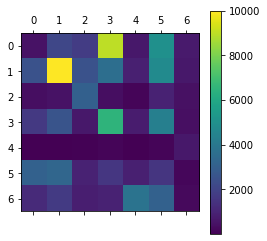

In [ ]:
# Matrix of edge counts
e = state.get_matrix()
plt.matshow(e.todense())
plt.colorbar();
plt.savefig("gj-edge-counts.svg")


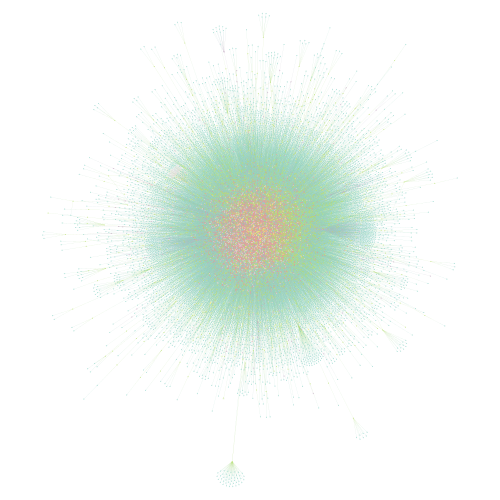

In [ ]:
state.draw(pos = u.vp.v_pos,output_size = (500,500));

In [ ]:
# Weighted network
# The number of groups is not set a priori
state = minimize_blockmodel_dl(u, state_args=dict(recs=[u.ep.e_weight], rec_types=["discrete-binomial"]))
print(state)

<BlockState object with 23 blocks (23 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, directed, with 30054 vertices and 92085 edges at 0x7f81b9ce6780>, at 0x7f81b3368780>


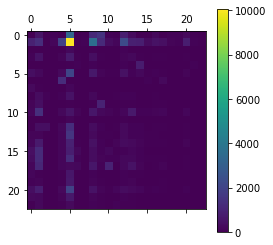

In [ ]:
# Matrix of edge counts
e = state.get_matrix()
plt.matshow(e.todense())
plt.colorbar();
plt.savefig("gj-edge-counts.svg")

In [ ]:
b = state.get_blocks()
np.unique(b.fa,return_counts=True)

(PropertyArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
               dtype=int32),
 array([14001,   525, 13115,  1007,   163,    93,   509,   269,   214,
           73,    47,    38]))

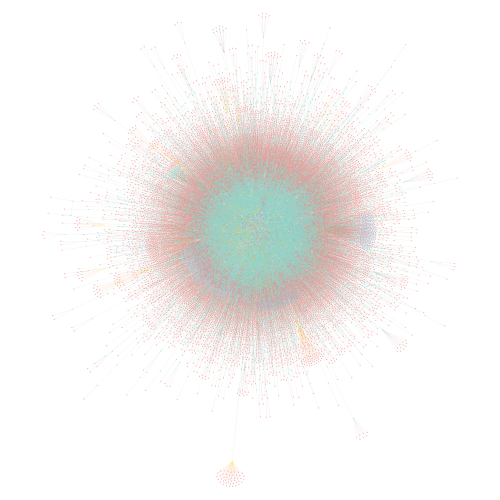

In [ ]:
state.draw(pos = u.vp.v_pos,output_size = (500,500));

In [ ]:
modules = {}
for m in np.unique(b.fa):
  modules[m] = GraphView(u, vfilt=b.fa == m)

In [ ]:
graph_draw(modules[1],output_size=(300,300));

In [ ]:
list(u.vp.v_id.get_2d_array([0])[0][b.fa == 4])


In [ ]:
# Fit a hierarchical SBM, which has a stronger explanatory power
hstate = minimize_nested_blockmodel_dl(u, deg_corr=True, state_args=dict(recs=[u.ep.e_weight], rec_types=["discrete-binomial"]))

In [ ]:
hstate.print_summary()

l: 0, N: 30054, B: 21
l: 1, N: 21, B: 5
l: 2, N: 5, B: 2
l: 3, N: 2, B: 1


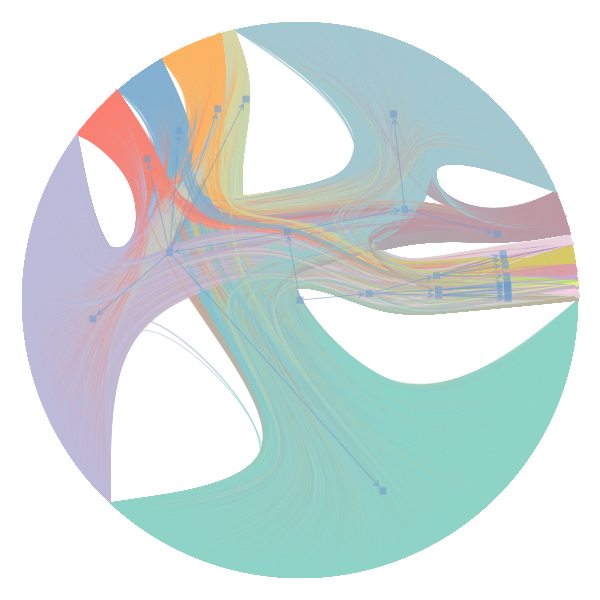

In [ ]:
hstate.draw();

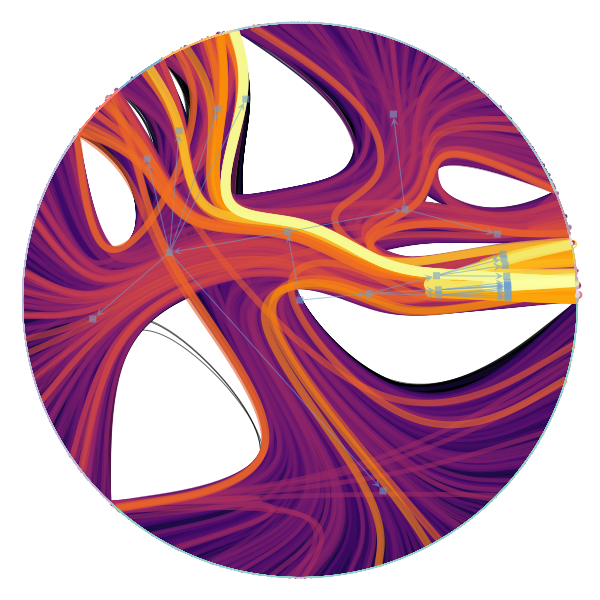

In [ ]:
from matplotlib import cm
hstate.draw(edge_color=prop_to_size(u.ep.e_weight, power=1, log=True), ecmap=(cm.inferno, .6),
           eorder=u.ep.e_weight, edge_pen_width=prop_to_size(u.ep.e_weight, 1, 10, power=1, log=True),
           edge_gradient=[]);

In [ ]:
# Entropy
print("H-SBM Entropy: ", -hstate.entropy())

H-SBM Entropy:  -735571.4730133172


In [ ]:
he = hstate.get_bstack()
print(he[1].list_properties())

b              (vertex)  (type: int32_t)
count          (vertex)  (type: int32_t)
count          (edge)    (type: int32_t)
None


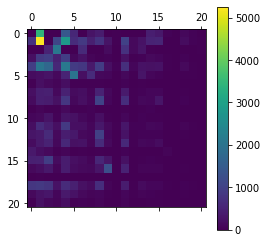

In [ ]:
he_adj = adjacency(he[1],weight=he[1].ep.count)
plt.matshow(he_adj.todense())
plt.colorbar();

In [ ]:
# Membership at lowest level (level 0)
membership_l0 = hstate.get_bs()[0]
np.unique(membership_l0, return_counts=True)

(PropertyArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                15, 16, 17, 18, 19, 20], dtype=int32),
 array([11106,  6727,  6976,  1025,   763,   932,   191,    80,  1123,
          309,    21,   241,    31,   104,   189,    29,    91,    17,
           65,    21,    13]))

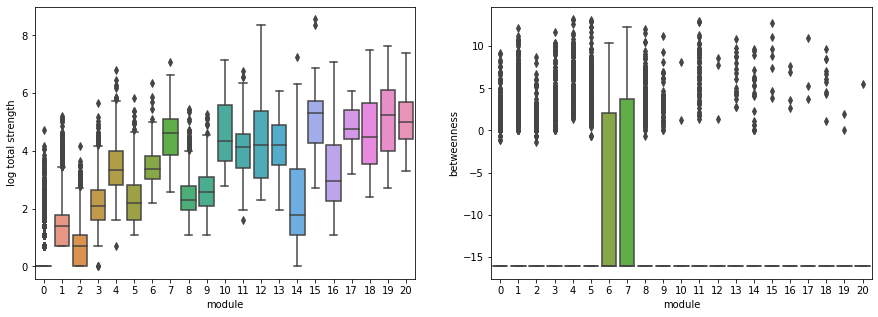

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.boxplot(y = np.log(s_in.fa + s_out.fa), x = membership_l0,ax = ax[0])
ax[0].set_xlabel('module')
ax[0].set_ylabel('log total strength')

sns.boxplot(y = np.log(vb.fa+0.0000001), x = membership_l0,ax = ax[1])
ax[1].set_xlabel('module')
ax[1].set_ylabel('betweenness');

In [ ]:
v_names = u.vp.v_id.get_2d_array([0])[0]
for m in [1,6,7,15,19,20]:
  print("Module "+str(m)+":\n", v_names[membership_l0 == m]) 


Module 1:
 ['pcampinouari' 'consultchou' 'grozeille_co' ... 'despartacus'
 'vanitasvostok' 'asselinfasselin']
Module 6:
 ['guardian' '1_to_li' 'lemediapourtous' 'Citizener' '1_RienRefraKTR'
 'chtikiff69' 'roger_berton' 'FondationGj' 'FrederickRouzes' 'le'
 'cykriltube' 'Xavier76100' 'patron_pme' 'daguilgot' 'CDewotine'
 'VotezPoisson' 'JeanneKarp' 'JP_Moinet' 'FabienLoir' 'axnslash'
 'Myosotisbasque' '76actu' 'Pwolf40067590' 'HerveLambel' '_Exar_Khun'
 'phiboud' '_max_lp' 'KatsMathieu' 'MartialPetiot' 'Pongo_Perdita'
 'Charlemagne881' 'fat37000' 'GLookathat' 'benoit_durand' 'Legiombre'
 'beau_spectacle' 'Hemail_79' 'K20LeFlowlower' 'Ghostbobb' 'mnlienemann'
 'missunny2' 'argane44' 'HariaChristelle' 'Philoulyon' 'news_isoloir'
 'mfrexit' 'jnckpop' 'ismael09428128' 'frhaz' 'Leboulonnais1'
 'Super_Yoyo_fr' 'IsabelScigliano' 'CoGeourjon' 'eetr_national'
 'LDCNewsagency' 'annick_chupin' 'JB_Drouet' 'drouet' 'fdubois81'
 'soospook' 'MolinariJulie' 'nala347' 'Daniel_Ber_1958' 'ChristalRoche'


### Average shortest path: 
### Has the (undirected) network a small world behaviour?



In [11]:
from google.colab import files
uploaded = files.upload()

Saving edgelist13.csv to edgelist13.csv
Saving edgelist14.csv to edgelist14.csv
Saving edgelist15.csv to edgelist15.csv
Saving edgelist18.csv to edgelist18.csv
Saving edgelist20.csv to edgelist20.csv
Saving edgelist21.csv to edgelist21.csv
Saving edgelist22.csv to edgelist22.csv
Saving edgelist23.csv to edgelist23.csv
Saving edgelist24.csv to edgelist24 (1).csv


In [ ]:
def read_gcc(df1): 
  # Nodes
  users = list(set(df1.source).union(df1.target.values))

  # Create graph
  g = Graph()
  g.add_vertex(len(users))

  # Add nodes id
  v_id = g.new_vp("string", vals = users)
  g.vp['v_id'] = v_id 

  # Dictionary to map nodes to graph-tool vertices
  vmap = {}
  for i, v in enumerate(g.vertices()):
      vmap[users[i]] = v

  # Edge attributes
  e_weight = g.new_ep("double")    

  # Add edges
  for r in range(len(df1)):
      try:
          e = g.add_edge(vmap[df1.source.iloc[r]],vmap[df1.target.iloc[r]])
          e_weight[e] = df1.weight.iloc[r]   
      except:
          pass   

  g.ep['e_weight'] = e_weight
  #tpos = graph_draw(g);
  #v_pos = g.new_vp("vector<double>",vals = tpos)  
  #g.vp['v_pos'] = v_pos

  # get gcc
  u = extract_largest_component(g,directed=False, prune=True)
  return(u) 

In [ ]:
# Average shortest path
def av_shortest_path_l(u1):
  all_sp = shortest_distance(u1, directed = False) #weight = u.ep.e_weight,
  vertex_avgs = graph_tool.stats.vertex_average(u1, all_sp)
  avg_path = np.mean(vertex_avgs[0])
  return(avg_path)

In [ ]:
# Read files
actes = ['13','14','15','18','20','21','22','23','24']
res_avpl = []
ns = []
gs_gcc = {}
for acte in actes:
  df1 = pd.read_csv('edgelist'+str(acte)+'.csv')
  u1 = read_gcc(df1)
  ns.append(u1.num_vertices())
  gs_gcc[acte] = u1 
  res_avpl.append(av_shortest_path_l(u1))  

In [15]:
print(ns,np.round(res_avpl,2))

[11263, 11721, 15315, 18313, 21142, 23790, 26106, 28165, 30054] [4.76 4.72 4.58 4.48 4.41 4.38 4.34 4.29 4.24]


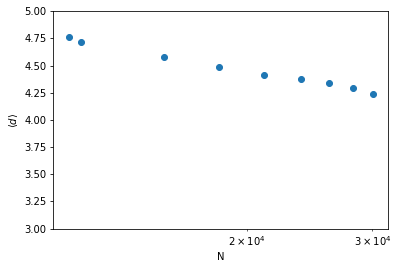

In [16]:
plt.plot(ns, res_avpl, 'o')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel(r'$\langle d \rangle$')
plt.ylim(3,5);